# **Stock Market Anomaly Detection**
**Capstone Project** | **Amandeep Yadav**
## Summary
**Goal:** The goal of this project is to build an automated system capable of detecting financial market anomalies (e.g. crashes, liquidity shocks and extreme volatility) without using labeled data.

**Key Definitions**:
* **Unsual:** Very large moves, spikes/dips, or unsually high volume compared to recent history.
* **Leakage-Free:** All features are computed using rolling windows of past data only (train on 2018, validate on 2019, test on 2020)


## 1. Setup and Loading the Dataset

In [ ]:
%pip install -q kagglehub

Note: you may need to restart the kernel to use updated packages.


c:\Users\ay272\OneDrive\Documents\Projects\stock_anomaly_detection\.venv\Scripts\python.exe: No module named pip


In [3]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm

c:\Users\ay272\OneDrive\Documents\Projects\stock_anomaly_detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
plot_path = '../plots'

os.makedirs(plot_path, exist_ok=True)

Downloading dataset from Kaggle

In [5]:
path = kagglehub.dataset_download("jacksoncrow/stock-market-dataset")

print(f"Downloading Data to : {path}")

In [6]:
for root, dirs, files in os.walk(path):
  if files:
    print(f"found {len(files)} files in {root}")
    print(f"Example: {files[0]}")

found 1 files in C:\Users\ay272\.cache\kagglehub\datasets\jacksoncrow\stock-market-dataset\versions\2
Example: symbols_valid_meta.csv
found 2165 files in C:\Users\ay272\.cache\kagglehub\datasets\jacksoncrow\stock-market-dataset\versions\2\etfs
Example: AAAU.csv
found 5884 files in C:\Users\ay272\.cache\kagglehub\datasets\jacksoncrow\stock-market-dataset\versions\2\stocks
Example: A.csv


# Load the Dataset

In [13]:
TICKERS = ['QQQ', 'AAPL', 'MSFT', 'NVDA', 'AMZN', 'AMD']
START_DATE = '2018-01-01'
END_DATE = '2020-04-01'

data_dict = {}

file_map = {}
for root, dirs, files in os.walk(path):
  for f in files:
    if f.endswith('.csv'):
      file_map[f] = os.path.join(root, f)

for ticker in TICKERS:
  filename = f"{ticker}.csv"

  if filename in file_map:
    filepath = file_map[filename]
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])

  df.set_index('Date', inplace=True)

  mask = (df.index >= START_DATE) & (df.index <= END_DATE) #Only data from 2018 to 2020
  df = df.loc[mask]

  data_dict[ticker] = df

  print(f"Loaded {ticker}: {len(df)} rows ({df.index.min().date()} to {df.index.max().date()})")

Loaded QQQ: 566 rows (2018-01-02 to 2020-04-01)
Loaded AAPL: 566 rows (2018-01-02 to 2020-04-01)
Loaded MSFT: 566 rows (2018-01-02 to 2020-04-01)
Loaded NVDA: 566 rows (2018-01-02 to 2020-04-01)
Loaded AMZN: 566 rows (2018-01-02 to 2020-04-01)
Loaded AMD: 566 rows (2018-01-02 to 2020-04-01)


**Note**: The Stock explicitly listed to watch wasn't in the provided kaggle dataset so I Downloaded the stock data for required period using `yfinance` library.

## 2: Feature Engineering
I constructed a robust feature set to represent market behavior. To prevent look-ahead bias, all statistics (mean, std, percentiles) are calculated on a **rolling window** of past days ($t-W$ to $t-1$).

**The Features:**
1. **Return Z-Score('ret_z'):** Measures how extreme today's return is compared to the volatility of the last 63 days.
2. **Volume Z-Score('vol_z'):** Measures if trading volume is unsually high (log-transformed to handle skew).
3. **Intraday Range Percentile ('range_pct'):** Ranks today's volatility (High-Low) against the distribution of the last 63 days.
4. **Severity ('severity'):** Measures how stressful a day was.
    * **~50-** A average day
    * **>80-** A midly stressful day.
    * **>95-** An extremely stresful day (Possibly Anomaly).

In [14]:
def calculate_features(df):
  df = df.copy()

  # Percentage change from previous Adj. Closing Price
  df['ret'] = df['Adj Close'].pct_change()
  df['log_vol'] = np.log(df['Volume'])
  df['range'] = (df['High'] - df['Low']) / df['Close']

  roll_ret = df['ret'].shift(1).rolling(window=63)
  df['ret_z'] = (df['ret'] - roll_ret.mean()) / roll_ret.std()
  ret_pct = norm.cdf(df['ret_z'].abs())

  roll_vol = df['log_vol'].shift(1).rolling(window=21)
  df['vol_z'] = (df['log_vol'] - roll_vol.mean()) / roll_vol.std()
  vol_pct = norm.cdf(df['vol_z'])

  df['range_pct'] = df['range'].rolling(window=64).apply(
      lambda x: (x.iloc[:-1] < x.iloc[-1]).mean()
  ) # Compares previous day with past 63 days to get it's Volatility Value

  severity = (ret_pct + vol_pct + df['range_pct']) / 3.0
  df['severity'] = severity * 100
  return df

In [15]:
processed_data = {}
for ticker, df in data_dict.items():
  processed_data[ticker] = calculate_features(df)

# Distribution of Engineered Features

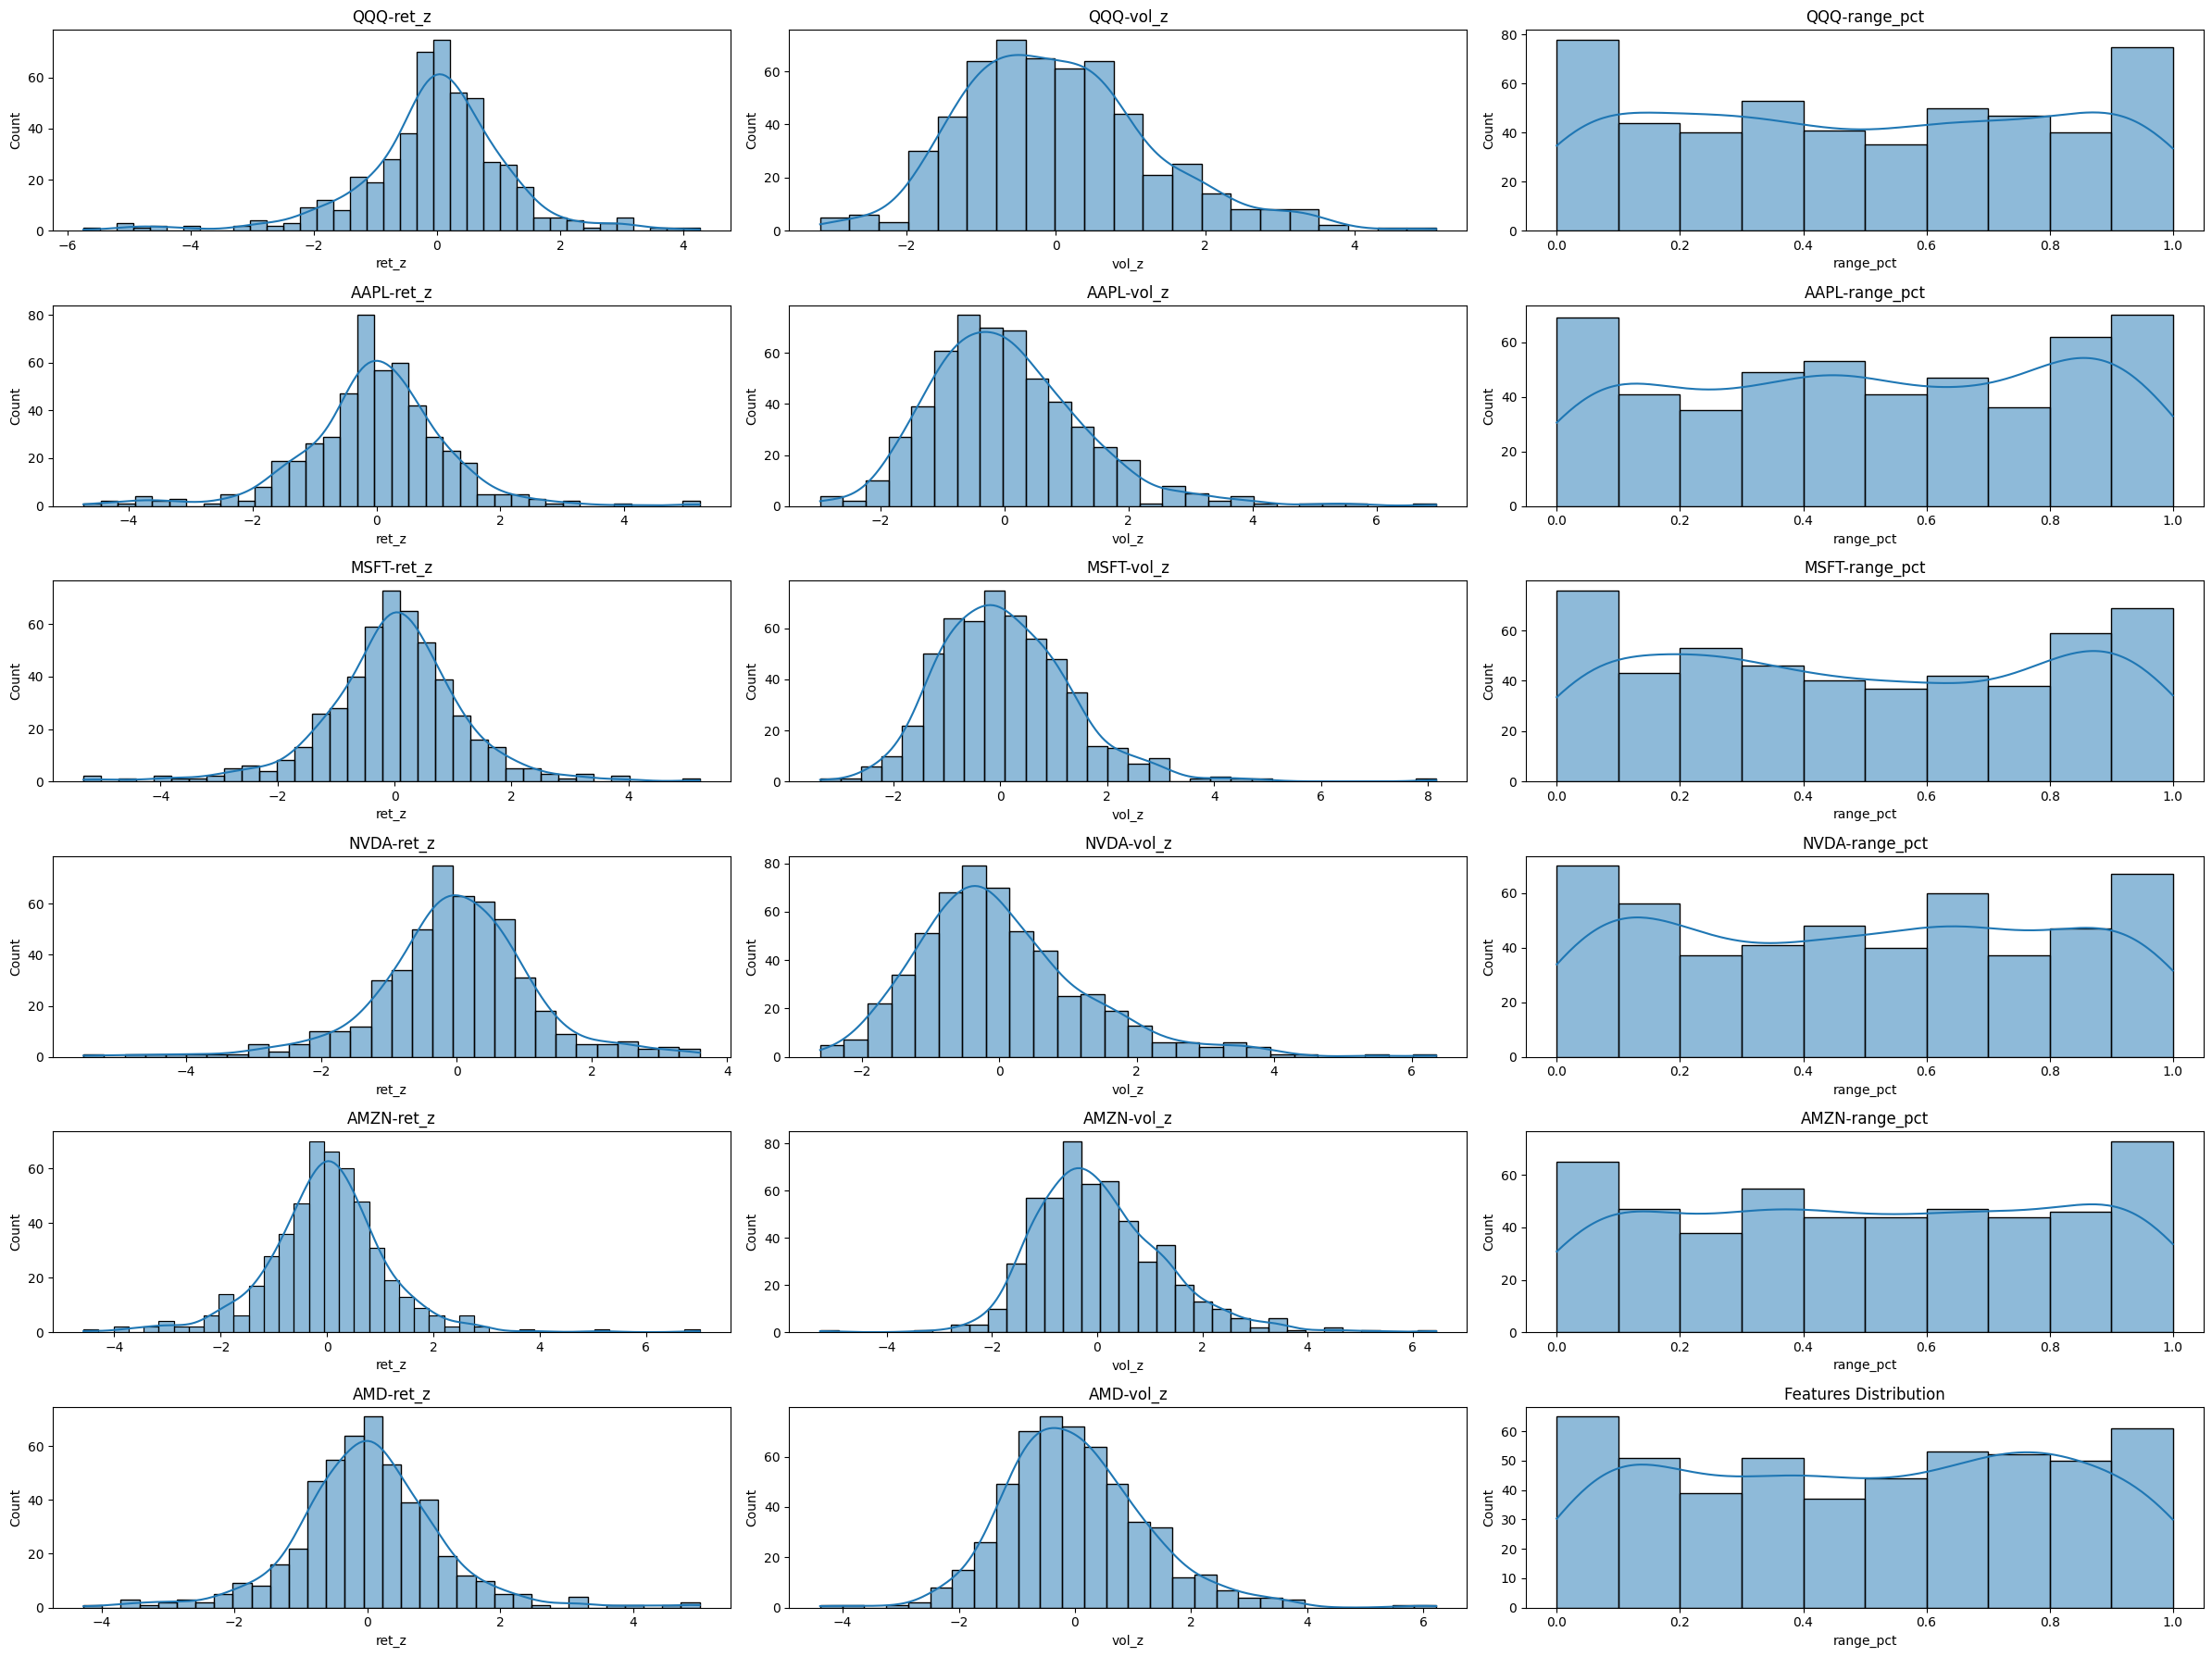

In [16]:
fig, ax = plt.subplots(6, 3, figsize=(6*4, 3*6))
for i, (ticker, df) in enumerate(processed_data.items()):
  for j, col in enumerate(['ret_z', 'vol_z', 'range_pct']):
    sns.histplot(data=df, x=col, kde=True, ax=ax[i, j])
    ax[i, j].set_title(f"{ticker}-{col}")
plt.title("Features Distribution")
plt.tight_layout()
plt.savefig(plot_path+'/feature_distribution.png')
plt.show()

## Simple Anomaly Detection

In [17]:
def detect_anomalies_simple(df):
  df = df.copy()
  df['anomaly'] = False
  df['type'] = ''
  df['why'] = ''

  Z_THRESH = 2.5 # Guidelines,
  RANGE_THRESH = 0.95

  is_crash = (df['ret'] < 0) & (df['ret_z'].abs() > Z_THRESH)
  is_spike = (df['ret'] > 0) & (df['ret_z'].abs() > Z_THRESH)
  is_vol_shock = (df['vol_z'] > Z_THRESH)
  is_range_shock = (df['range_pct'] > RANGE_THRESH)

  # Labeling the type of anomaly
  df.loc[is_crash, 'type'] += 'crash '
  df.loc[is_spike, 'type'] += 'spike '
  df.loc[is_vol_shock, 'type'] += 'vol_shock '
  df.loc[is_range_shock, 'type'] += 'range_shock'

  df.loc[(is_crash | is_spike), 'why'] += '|ret_z|>2.5 '
  df.loc[is_vol_shock, 'why'] += "vol_z>2.5 "
  df.loc[is_range_shock, 'why'] += "range_pct>0.95 "

  df['type'] = df['type'].str.strip().replace(' ', ' + ', regex=False)
  df['why'] = df['why'].str.strip().replace(' ', ', ', regex=False)
  df['anomaly'] = df['type'] != ''

  return df

In [18]:
for ticker, df in processed_data.items():
  df_final = detect_anomalies_simple(df)
  processed_data[ticker] = df_final

### **Deliverable - (Data Anomaly Card)**

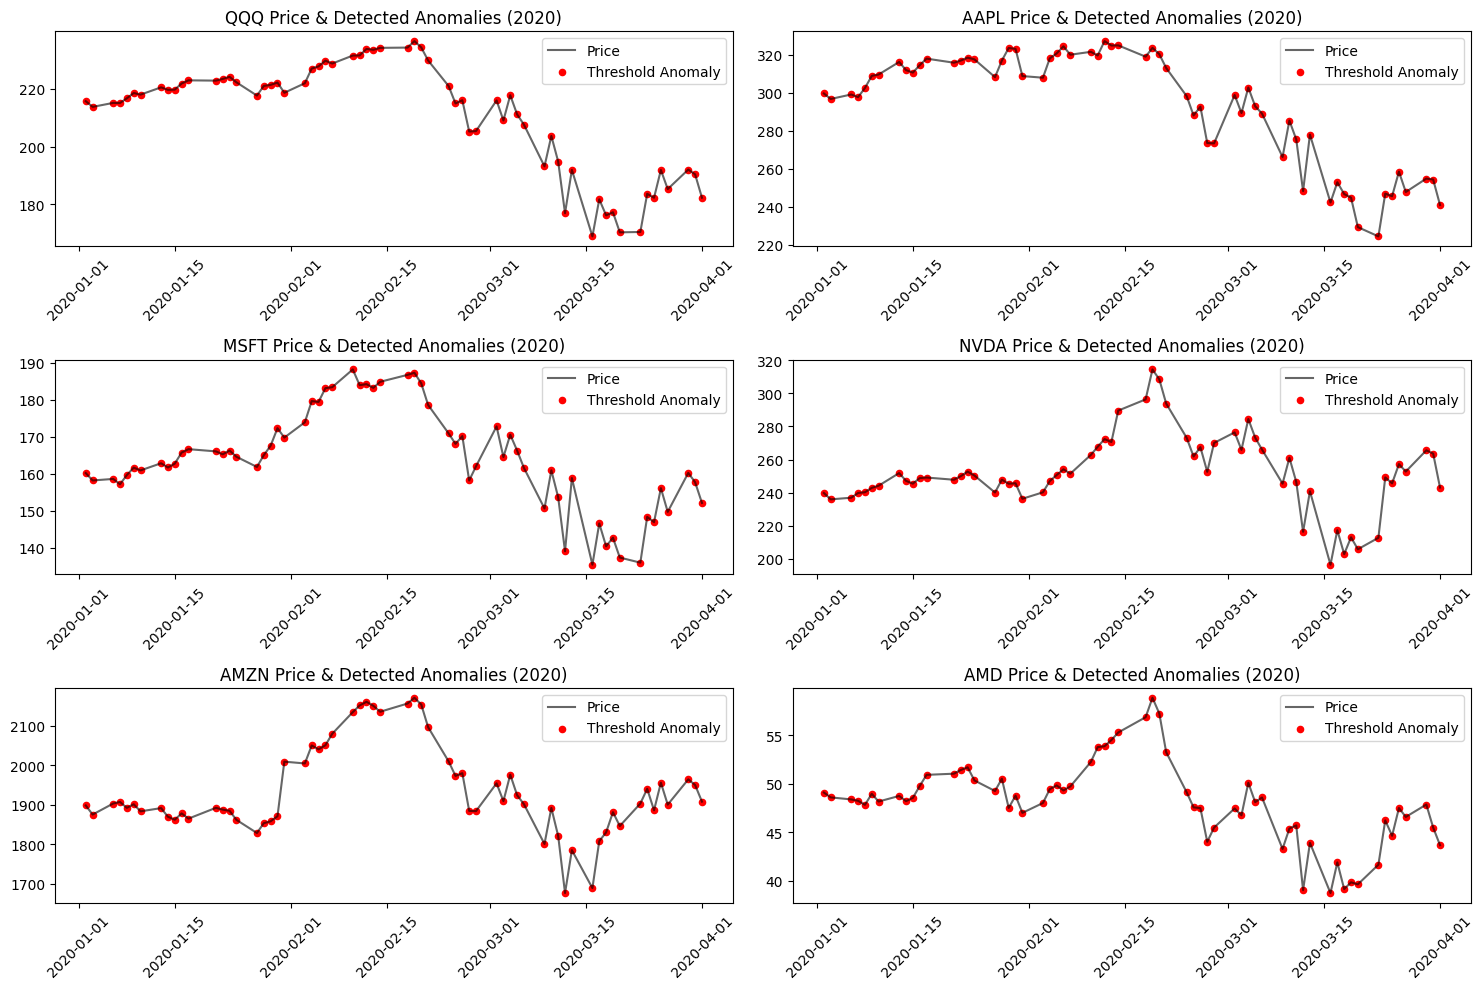

In [19]:
all_dfs = []
for ticker, df in processed_data.items():
  temp_df = df.copy()
  temp_df['ticker'] = ticker
  temp_df['Date'] = df.index
  all_dfs.append(temp_df)

big_df = pd.concat(all_dfs)

features = ["ticker", "anomaly", "type", "ret", "ret_z", "vol_z", "range_pct", "why"]
days_mask = (big_df.index >= '2019-01-01') & (big_df.index <= '2020-04-01')
data_anomaly_card = big_df[features][days_mask & big_df['anomaly']==True]

data_anomaly_card.to_csv('Data_Anomaly_Card_2020.csv')

fig, ax = plt.subplots(3, 2, figsize=(15, 10))
ax = ax.ravel()

for i, ticker in enumerate(TICKERS):
  temp_df = big_df[big_df['ticker']==ticker]
  days_mask = (temp_df.index >= '2020-01-01') & (temp_df.index <= '2020-04-01')
  temp_df = temp_df[days_mask]
  anomalies = temp_df[temp_df['anomaly']==True]
  ax[i].plot(temp_df.index, temp_df['Adj Close'], label='Price', color='black', alpha=0.6)
  ax[i].scatter(temp_df.index, temp_df['Adj Close'], color='red', s=20, label='Threshold Anomaly')
  ax[i].set_title(f"{ticker} Price & Detected Anomalies (2020)")
  ax[i].tick_params(axis='x', rotation=45)
  ax[i].legend()
plt.tight_layout()
plt.savefig(plot_path+'/threshold_anomalies.png')
plt.show()

## Standard Scaling features for Unsupervised Models

In [20]:
all_dfs = []
for ticker, df in processed_data.items():
  temp_df = df.copy()
  temp_df['ticker'] = ticker
  all_dfs.append(temp_df)

big_df = pd.concat(all_dfs) #Stacking all ticker data
features = ['ret_z', 'vol_z', 'range_pct']

scaler = StandardScaler()
mask_2018 = (big_df.index>='2018-01-01') & (big_df.index <= '2018-12-31')
X_train = big_df.loc[mask_2018, features].dropna()

scaler.fit(X_train) # Only fitting on 2018 data

print(f"\nScaler fitted on {len(X_train)} rows from 2018.")
print(f"Means: {scaler.mean_.round(3)}")

scaled_feature_names = [f"{f}_scaled" for f in features]

scaled_data_dict = {}
for ticker, df in processed_data.items():
  df_copy = df.copy()
  valid_rows = df_copy[features].notna().all(axis=1)

  if valid_rows.any():
    X_original = df_copy.loc[valid_rows, features]
    X_scaled = scaler.transform(X_original)

    df_copy.loc[valid_rows, scaled_feature_names] = X_scaled
  scaled_data_dict[ticker] = df_copy


Scaler fitted on 1122 rows from 2018.
Means: [-0.038  0.06   0.541]


In [21]:
final_data, scaler = scaled_data_dict, scaler

## 3. KMeans Detector
**Logic:** Markets have different "regimes" (e.g., Calm/Bull Market vs. Volatile/Bear Market). K-Means groups days into these regimes.

**Anomaly Detection:** I calculated the distance of each point to its cluster center. If the distance is greater than the **95th Percentile** of that cluster's training distances, it is flagged as an anomaly.

### Hyperparameter Tuning
* **K (Clusters):** Chosen via Silhouette Score and Elbow Method on 2018 data.
* **Selected K:** 3 (Represents roughly: Low Volatility, High Volatility, and Extreme/Crash regimes.) Tuned using Validation data on 2019. Kept FlagRate over all Anomalies to be between $2$%-$8$% while maximizing Overlap with anomalies (considered above $95th$ Percentile of overall data).

In [22]:
FEATURE_COLS = ['ret_z_scaled', 'vol_z_scaled', 'range_pct_scaled']
TRAIN_START = '2018-01-01'
TRAIN_END = '2018-12-31'
VAL_START = '2019-01-01'
VAL_END = '2019-12-31' # For tuning k and q later

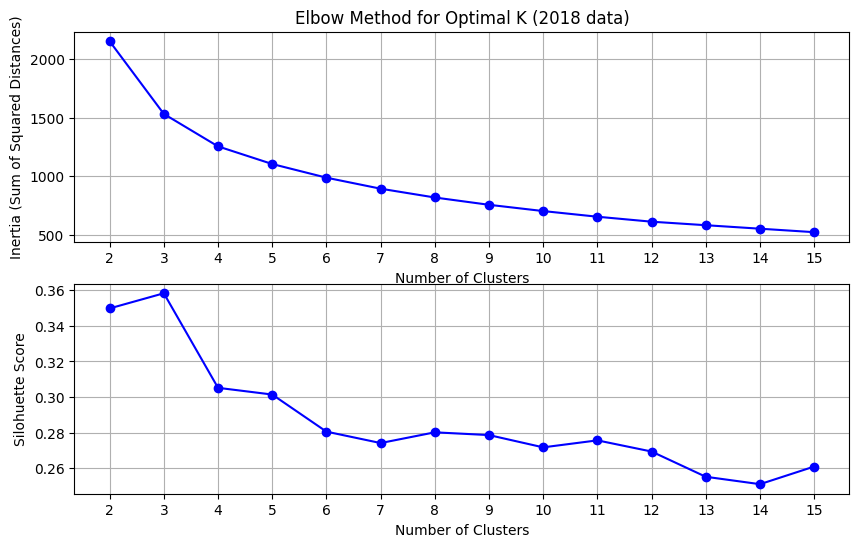

In [23]:
def plot_elbow_curve(data_dict):
  X_train_list = [] # Append all ticker data of 2018 for training KMeans

  for ticker, df in data_dict.items():
    mask_train = (df.index >= TRAIN_START) & (df.index<=TRAIN_END)

    if all(col in df.columns for col in FEATURE_COLS):
      X_train_list.append(df.loc[mask_train, FEATURE_COLS])

  X_train = pd.concat(X_train_list).dropna()

  inertias = []
  s_scores = []

  for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train)
    inertias.append(kmeans.inertia_)
    s_scores.append(silhouette_score(X_train, labels))

  fig, ax = plt.subplots(2, 1, figsize=(10, 6))

  ax[0].plot(range(2, 16), inertias, marker='o', linestyle='-', color='b')
  ax[0].set_title('Elbow Method for Optimal K (2018 data)')
  ax[0].set_xlabel('Number of Clusters')
  ax[0].set_ylabel('Inertia (Sum of Squared Distances)')
  ax[0].grid(True)
  ax[0].set_xticks(range(2, 16))

  ax[1].plot(range(2, 16), s_scores, marker='o', linestyle='-', color='b')
  ax[1].set_xlabel('Number of Clusters')
  ax[1].set_ylabel('Silohuette Score')
  ax[1].grid(True)
  ax[1].set_xticks(range(2, 16))
  plt.savefig(plot_path+'/elbow_and_silhouette_kmeans.jpg')
  plt.show()

plot_elbow_curve(final_data)

Validating and Tuning q choices on Validation Data

In [24]:
def tune_k_q(data_dict, k=3, q_values=[95, 96, 96.5, 97.5, 98, 99]):
  val_dfs = []
  for ticker, df in data_dict.items():
    mask_val = (df.index >= VAL_START) & (df.index <= VAL_END)
    temp = df.loc[mask_val, FEATURE_COLS + ['ret']].copy()

    abs_ret = temp['ret'].abs()
    top_r_thresh = np.percentile(abs_ret.dropna(), 95)
    temp['is_top_r'] = abs_ret > top_r_thresh # For validating I marked anything above 95th percentile as an anomaly

    val_dfs.append(temp)
  big_val = pd.concat(val_dfs).dropna()

  train_dfs = []
  for ticker, df in data_dict.items():
    mask_train = (df.index >= TRAIN_START) & (df.index<= TRAIN_END)
    train_dfs.append(df.loc[mask_train, FEATURE_COLS])
  X_train = pd.concat(train_dfs).dropna()

  results = []

  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(X_train)

  labels_train = kmeans.labels_
  centers = kmeans.cluster_centers_
  train_dists = np.linalg.norm(
      X_train.values - centers[labels_train],
      axis=1
  )
  labels_val = kmeans.predict(big_val[FEATURE_COLS])
  val_dists = np.linalg.norm(
      big_val[FEATURE_COLS].values - centers[labels_val],
      axis=1
  )

  for q in q_values:
    cluster_thresh = {}
    for c in np.unique(labels_train):
      cluster_thresh[c] = np.percentile(
          train_dists[labels_train == c], q
      )

    flags = np.array([
        val_dists[i] > cluster_thresh[labels_val[i]] for i in range(len(val_dists))
    ])

    flag_rate = np.mean(flags)

    if np.sum(flags) > 0:
      overlap_precision = np.mean(big_val.loc[flags, 'is_top_r'])
    else:
      overlap_precision=0.0

    results.append({
        'q':q,
        'Flag Rate %': round(flag_rate*100, 2),
        'Overlap %': round(overlap_precision*100, 2),
    })

  results_df = pd.DataFrame(results)
  valid_results = results_df[
      (results_df['Flag Rate %'] >= 2) &
      (results_df['Flag Rate %'] <= 8)
  ].sort_values(by='Overlap %', ascending=False)

  print("Top Hyperparameters:")
  print(valid_results.head(10))

  return valid_results

In [25]:
tuning_results = tune_k_q(final_data)

Top Hyperparameters:
      q  Flag Rate %  Overlap %
0  95.0         4.76      27.78
1  96.0         3.37      27.45
2  96.5         2.84      25.58
3  97.5         2.38      25.00


Running KMeans on Test data (2019-2020)

In [26]:
def run_kmeans(data_dict, k, q):
  print(f"Training K-Means Detector with k={k} & q={q}...")

  X_train_list = []
  for ticker, df in data_dict.items():
    mask_train = (df.index >= TRAIN_START) & (df.index<= TRAIN_END)
    X_train_list.append(df.loc[mask_train, FEATURE_COLS])
  X_train = pd.concat(X_train_list).dropna()

  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(X_train)

  labels_train = kmeans.labels_
  centers = kmeans.cluster_centers_

  train_dists = np.linalg.norm(
      X_train.values - centers[labels_train],
      axis=1
  )

  cluster_thresh = {}
  for c in np.unique(labels_train):
    cluster_thresh[c] = np.percentile(
        train_dists[labels_train == c], q
    )

  results = {}
  for ticker, df in data_dict.items():
    df_out = df.copy()
    valid_rows = df_out[FEATURE_COLS].notna().all(axis=1)
    X_all = df_out.loc[valid_rows, FEATURE_COLS]

    if len(X_all) > 0:
      labels_all = kmeans.predict(X_all[FEATURE_COLS])
      distances = np.linalg.norm(
          X_all[FEATURE_COLS].values - centers[labels_all],
          axis=1
      )
      df_out['kmeans_dist'] = np.nan
      df_out['kmeans_anomaly'] = False
      df_out.loc[valid_rows, 'kmeans_dist'] = distances
      df_out.loc[valid_rows, 'kmeans_anomaly'] = np.array([
          distances[i] > cluster_thresh[labels_all[i]] for i in range(len(distances))
      ])
    results[ticker] = df_out
  return results


In [27]:
CHOSEN_K = 3
CHOSEN_Q = 95
kmeans_results = run_kmeans(final_data, CHOSEN_K, CHOSEN_Q)

Training K-Means Detector with k=3 & q=95...


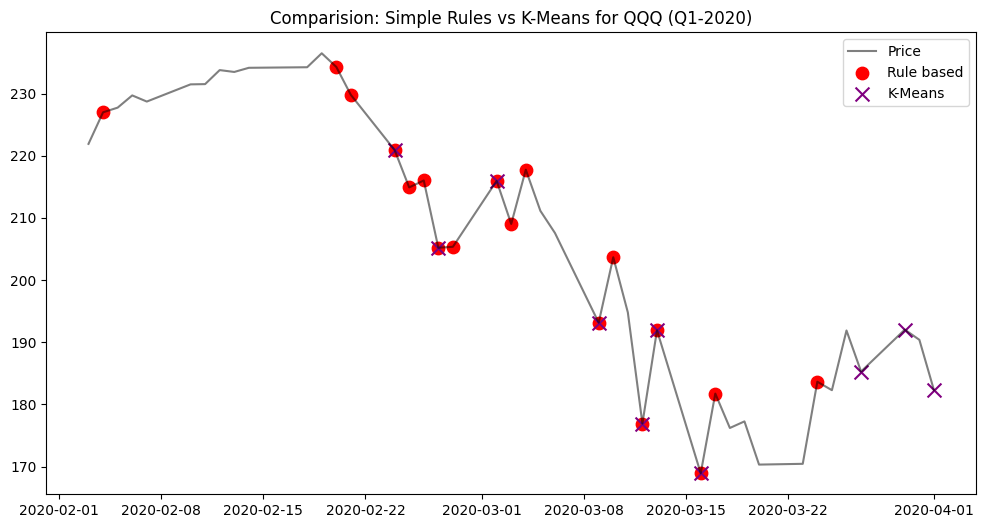

In [28]:
ticker = "QQQ"
df = kmeans_results[ticker]
subset = df[(df.index >= '2020-02-01') & (df.index <= '2020-04-01')]
plt.figure(figsize=(12, 6))

plt.plot(subset.index, subset['Adj Close'], color='black', alpha=0.5, label='Price')

simple_anom = subset[subset['anomaly'] == True]
plt.scatter(simple_anom.index, simple_anom['Adj Close'], color='red', s=80, label='Rule based', marker='o')

kmeans_anom = subset[subset['kmeans_anomaly']==True]
plt.scatter(kmeans_anom.index, kmeans_anom['Adj Close'], color='purple', s=100, label='K-Means', marker='x')
plt.title(f"Comparision: Simple Rules vs K-Means for {ticker} (Q1-2020)")
plt.legend()
plt.savefig(plot_path+'/simple_rules_Vs_kmeans.png')
plt.show()

## 4. DBSCAN Detection (Walk-Forward)
**Logic:** DBSCAN groups dense clouds of data points. Points that lie in low-density regions (far from neighbors) are labeled as noise (-1) and treated as anomalies.

**Walk-Forward Validation:** To simulate real trading, I retrained the model on an expanding window every month.

### Hyperparameter Tuning
* **Epsilon (`eps`):** The maximum distance between two samples for one to be considered as in the neighborhood of the other.
* **Selection Method:** I used a **K-Distance Graph** to find the "elbow" (point of maximum curvature).
* **Selected Parameters:** `eps=0.6`, `min_samples=20`.

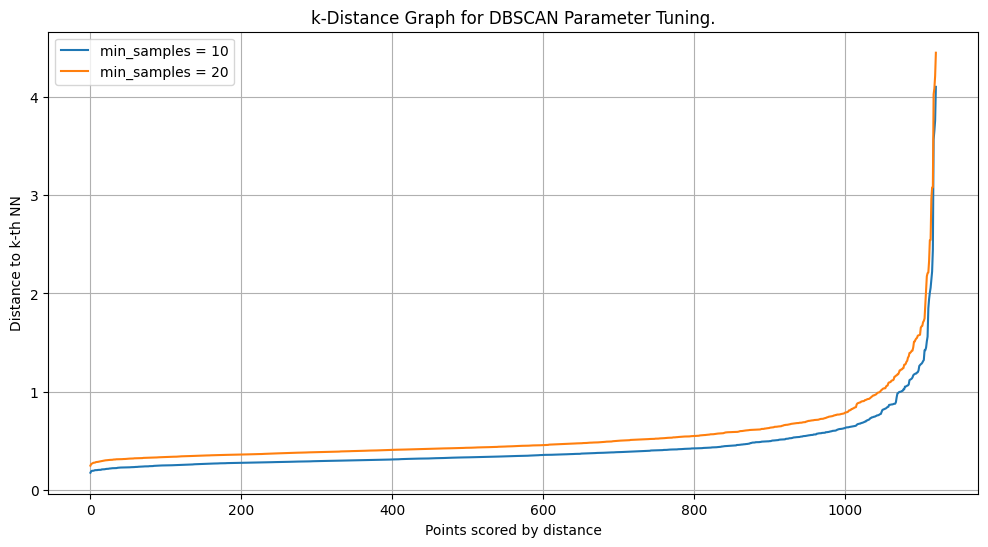

In [29]:
def plot_k_distance(data_dict, k_values=[10, 20]):
  X_train_list = []

  for ticker, df in data_dict.items():
    mask_2018 = (df.index >= TRAIN_START) & (df.index <= TRAIN_END)

    if all(col in df.columns for col in FEATURE_COLS):
      X_train_list.append(df.loc[mask_2018, FEATURE_COLS])

  X_train = pd.concat(X_train_list).dropna()

  plt.figure(figsize=(12, 6))
  for k in k_values:
    nbrs = NearestNeighbors(n_neighbors=k).fit(X_train)
    distances, indices = nbrs.kneighbors(X_train)

    k_distances = np.sort(distances[:,k-1])
    plt.plot(k_distances, label=f"min_samples = {k}")

  plt.title("k-Distance Graph for DBSCAN Parameter Tuning.")
  plt.xlabel('Points scored by distance')
  plt.ylabel('Distance to k-th NN')
  plt.grid(True)
  plt.legend()
  plt.savefig(plot_path+'/k_distance_dbscan.png')
  plt.show()

plot_k_distance(kmeans_results)

In [30]:
def run_dbscan(data_dict, eps, min_samples):
  results = {}

  for ticker, df in data_dict.items():
    df_out = df.copy()
    df_out['dbscan_anomaly'] = False
    df_out['dbscan_label'] = np.nan
    results[ticker] = df_out

  start_date = pd.Timestamp('2019-01-01')
  end_date = pd.Timestamp('2020-04-01')
  dates = pd.date_range(start=start_date, end=end_date, freq='MS')

  for current_month in dates:
    block_end = current_month + pd.offsets.MonthEnd(1)

    epoch_X = []

    for ticker, df in results.items():
      mask = df.index <= block_end

      subset = df.loc[mask, FEATURE_COLS].copy()
      subset['ticker'] = ticker

      epoch_X.append(subset)

    X_epoch = pd.concat(epoch_X).dropna()

    if len(X_epoch) < min_samples:
      continue

    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)

    labels = db.fit_predict(X_epoch[FEATURE_COLS])

    X_epoch['label'] = labels

    for ticker in results.keys():
      mask_block = (
          (results[ticker].index >= current_month) &
          (results[ticker].index <= block_end)
      )

      ticker_mask = X_epoch['ticker'] == ticker
      ticker_data = X_epoch[ticker_mask]
      idx = results[ticker].index[mask_block]
      idx = idx.intersection(ticker_data.index)

      if idx.empty:
        continue

      labs = ticker_data.loc[idx, 'label']

      results[ticker].loc[idx, 'dbscan_label'] = labs
      results[ticker].loc[idx, 'dbscan_anomaly'] = (labs == -1)

  return results

In [31]:
db_results = run_dbscan(kmeans_results, eps=0.6, min_samples=20)

In [32]:
total_days = 0
total_anomalies = 0
for ticker, df in db_results.items():
  mask_2019 = (df.index >= '2019-01-01') & (df.index <= '2019-12-31')
  total_days += mask_2019.sum()
  total_anomalies += df.loc[mask_2019, 'dbscan_anomaly'].sum()

print(f"DBSCAN Flag Rate: {total_anomalies/total_days * 100:.2f}%")

DBSCAN Flag Rate: 5.69%


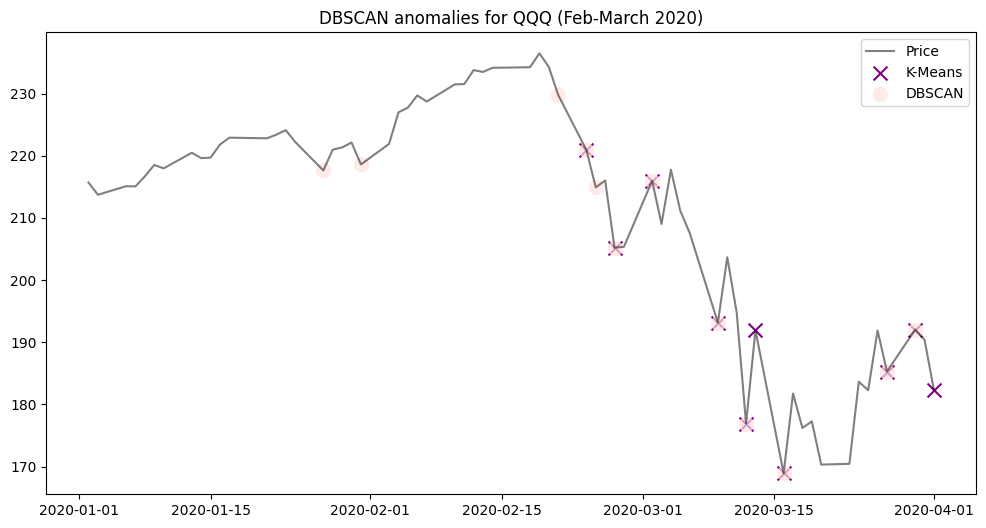

In [33]:
ticker = "QQQ"
df = db_results[ticker]
subset = df[(df.index >= '2020-01-01') & (df.index <= '2020-04-01')]
plt.figure(figsize=(12, 6))

plt.plot(subset.index, subset['Adj Close'], color='black', alpha=0.5, label='Price')

kmeans_anom = subset[subset['kmeans_anomaly']==True]
plt.scatter(kmeans_anom.index, kmeans_anom['Adj Close'], color='purple', s=100, label='K-Means', marker='x')

db_anom = subset[subset['dbscan_anomaly']==True]
plt.scatter(db_anom.index, db_anom['Adj Close'], color='mistyrose', s=100, label='DBSCAN', marker='o', alpha=0.7)
plt.title(f"DBSCAN anomalies for {ticker} (Feb-March 2020)")
plt.legend()
plt.savefig(plot_path+'/QQQ_anomalie_kmeans_vs_dbscan.png')
plt.show()

## Visualizing Clusters

In [34]:
def visualize_cluster_dbscan(data_dict, ticker='QQQ', year='2019'):
  df = data_dict[ticker]
  mask = df.index.astype(str).str.startswith(year)
  subset = df.loc[mask]

  plt.figure(figsize=(12, 8))
  noise = subset[subset['dbscan_label'] == -1]
  clusters = subset[subset['dbscan_label'] != -1]

  sns.scatterplot(
      data=clusters,
      x='ret_z_scaled',
      y='vol_z_scaled',
      hue='dbscan_label',
      palette='viridis',
      s=60,
      alpha=0.6,
      legend='full'
  )

  plt.scatter(
      noise['ret_z_scaled'],
      noise['vol_z_scaled'],
      color='red',
      marker='x',
      s=100,
      label='Anomaly (Noise -1)'
  )

  plt.axvline(x=2.5, color='black', linestyle='--', alpha=0.3)
  plt.axvline(x=-2.5, color='black', linestyle='--', alpha=0.3)
  plt.axhline(y=2.5, color='black', linestyle='--', alpha=0.3)
  plt.axhline(y=-2.5, color='black', linestyle='--', alpha=0.3)

  plt.title(f'DBSCAN Clustering: {ticker} ({year})\nReturn vs. Volume')
  plt.xlabel('Scaled Return Z-Score (Price Move)')
  plt.ylabel('Scaled Volume Z-Score (Activity)')
  plt.legend(loc='upper right')
  plt.grid(alpha=0.3)
  plt.savefig(plot_path+'/dbscan_cluster_visualization.png')
  plt.show()

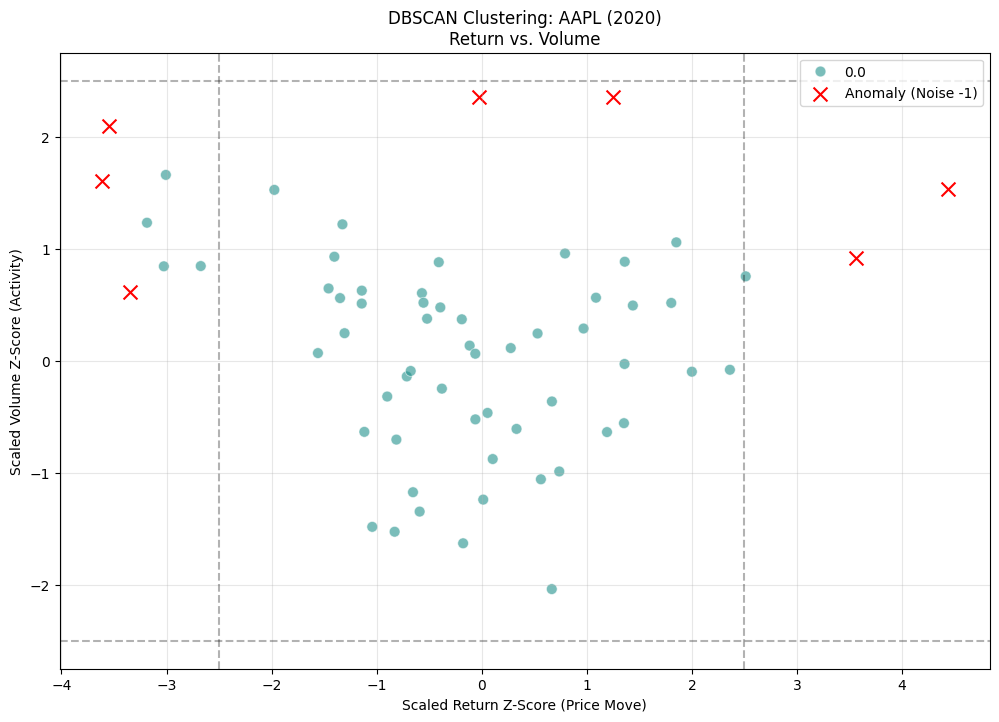

In [35]:
visualize_cluster_dbscan(db_results, ticker='AAPL', year='2020')

## 5. Consensus & Validation
I used a **Union** approach for maximum safety:
* **Strong Signal:** Both K-Means and DBSCAN flag the day.
* **Weak Signal:** One model disagrees with another.
* **Decision:** I consider a day "Anomalous" if either model flags it (Union), ensuring I catch all major events even if one model is less sensitive.


In [36]:
def consensus_report(data_dict, target='2020-03'):
  consensus_anomalies = []

  for ticker in data_dict.keys():
    df = data_dict[ticker]

    dates = df.loc[target].index

    for date in dates:
      k_flag = df.loc[date, 'kmeans_anomaly']
      d_flag = df.loc[date, 'dbscan_anomaly']

      if k_flag or d_flag:
        row = df.loc[date]
        consensus_anomalies.append({
            'Date': date.date(),
            'Ticker': ticker,
            'Return': f"{row['ret']:.2%}",
            'Volume': f"{np.exp(row['log_vol']):.0f}",
            'Consensus': 'STRONG SIGNAL' if k_flag and d_flag else 'WEAK SIGNAL',
            'K-Means': 'Yes' if k_flag else 'No',
            'DBSCAN': 'Yes' if d_flag else 'No',
        })

  if consensus_anomalies:
    df_res = pd.DataFrame(consensus_anomalies)
  else:
    print("No consensus anomalies found (Models disagreed or no anomalies.)")
  return df_res

### Case Study: March 2020 Crash
The table below shows the model performance during the COVID-19 crash (March, 2020).

* **Expectation:** Deep negative returns should be flagged.
* **Result:** Both model successfully flagged the major crash days for QQQ, MSFT, AAPL, NVDA and AMD.


In [37]:
consensus_data = consensus_report(db_results, target='2020-02')

print(f"Consesnsus data (UNION): ")
print(consensus_data)

Consesnsus data (UNION): 
          Date Ticker  Return     Volume      Consensus K-Means DBSCAN
0   2020-02-21    QQQ  -1.92%   66017200    WEAK SIGNAL      No    Yes
1   2020-02-24    QQQ  -3.86%   84522600  STRONG SIGNAL     Yes    Yes
2   2020-02-25    QQQ  -2.72%   97743000    WEAK SIGNAL      No    Yes
3   2020-02-27    QQQ  -5.01%  121822600  STRONG SIGNAL     Yes    Yes
4   2020-02-27   AAPL  -6.54%   80151400  STRONG SIGNAL     Yes    Yes
5   2020-02-28   AAPL  -0.06%  106721200    WEAK SIGNAL      No    Yes
6   2020-02-04   MSFT   3.29%   36433300    WEAK SIGNAL     Yes     No
7   2020-02-24   MSFT  -4.31%   68311100  STRONG SIGNAL     Yes    Yes
8   2020-02-27   MSFT  -7.05%   93174900  STRONG SIGNAL     Yes    Yes
9   2020-02-28   MSFT   2.42%   97073600    WEAK SIGNAL      No    Yes
10  2020-02-10   NVDA   4.52%   13240200  STRONG SIGNAL     Yes    Yes
11  2020-02-11   NVDA   1.87%   15963900    WEAK SIGNAL      No    Yes
12  2020-02-14   NVDA   7.02%   26048100  STRONG SI

## 6. Evaluation & Visualization
Visual inspection of the returns during the anomaly periods allowed me to validate the "Ground Truth." The plots below highlight the extreme volatility in March 2020, confirming that the statistical anomalies align with visual outliers.

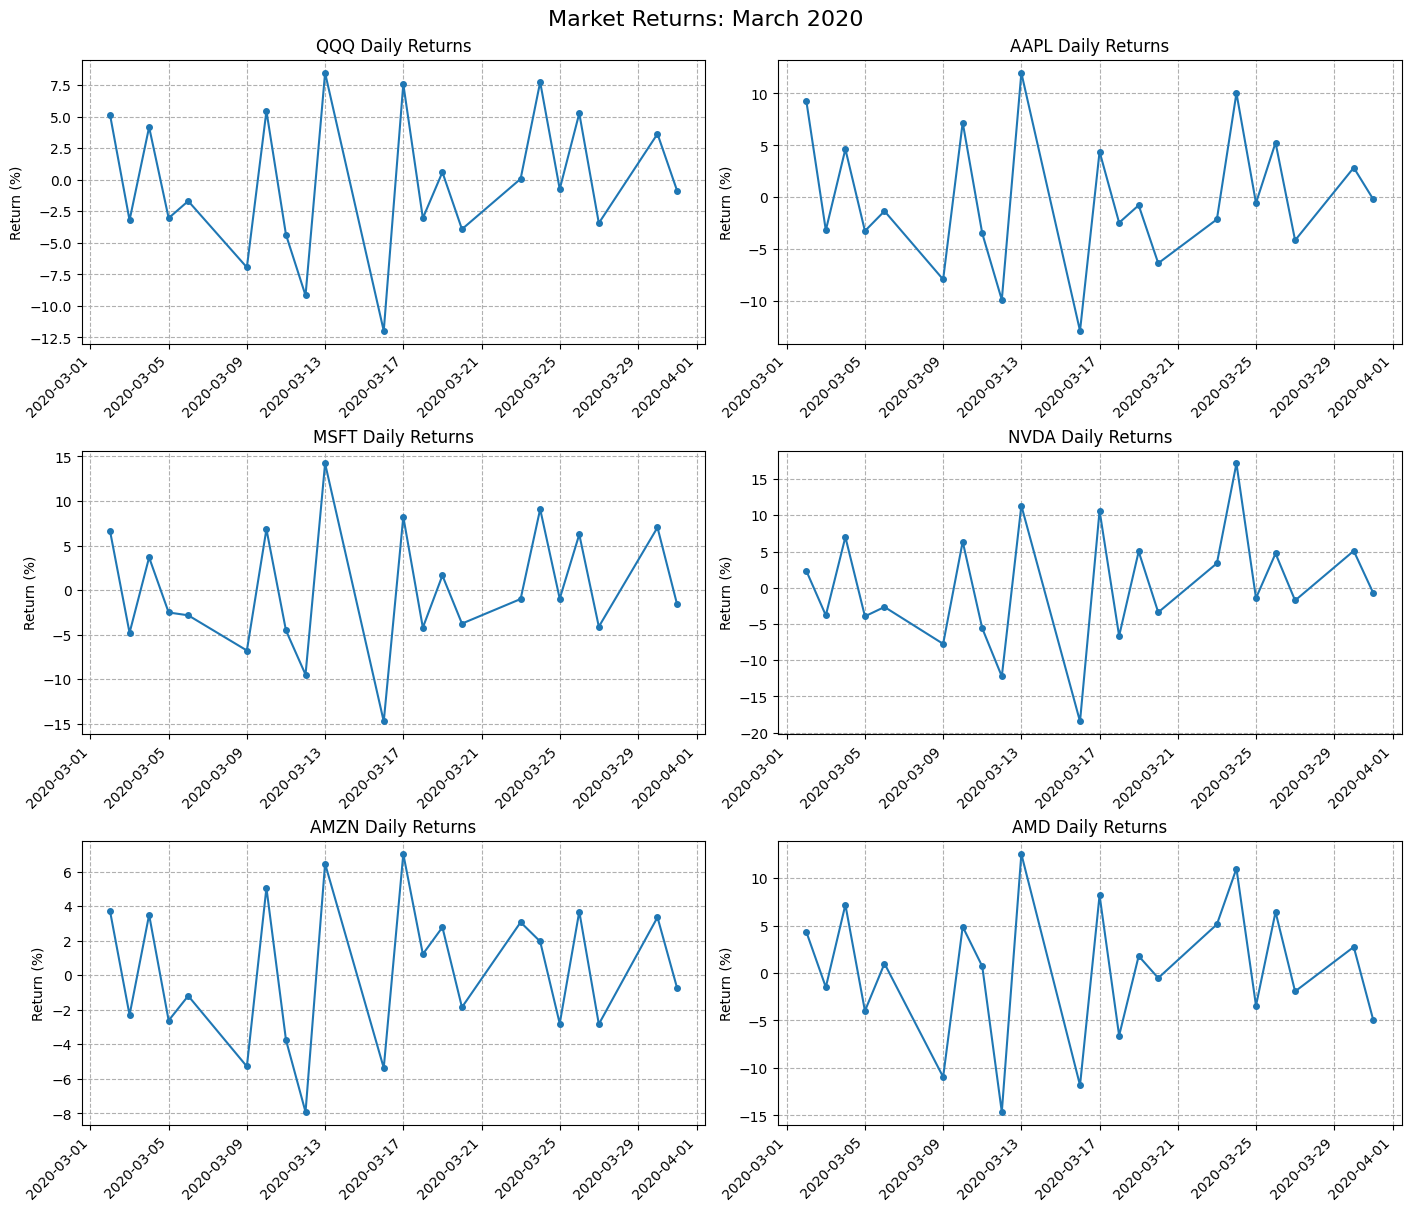

In [38]:
def plot_return_data(data_dict, year, month):
  tickers = list(data_dict.keys())

  fig, axes = plt.subplots(3, 2, figsize=(14, 4*3), constrained_layout=True)

  axes = axes.flatten()

  start_date = pd.Timestamp(f"{year} - {month:02d}-01")
  end_date = start_date + pd.offsets.MonthEnd(1)

  for i, ticker in enumerate(tickers):
    ax = axes[i]
    df = data_dict[ticker]
    mask = (df.index >= start_date) & (df.index <= end_date)
    subset = df.loc[mask]

    y_values = subset['ret'] * 100

    ax.plot(subset.index, y_values, marker='o', linestyle='-', linewidth=1.5, markersize=4)
    ax.set_title(f"{ticker} Daily Returns")
    ax.set_ylabel("Return (%)")
    ax.grid(True, which='both', linestyle='--')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
  plt.suptitle(f"Market Returns: {start_date.strftime('%B %Y')}", fontsize=16)
  plt.savefig(plot_path+'/market_returns_2020.png')
  plt.show()
plot_return_data(db_results, year=2020, month=3)


### Evaluating KMeans Quality:

**Results & Interpretation:**
As shown in the *Centroid Stability Plot* below, the cluster centers for all scaled features "Return Z-Score", "Vol Z-Score" and "Range Pct." across three distict clusters:
1. **Bearish Regime (Cluster 0):** Consistently stays at the bottom, representing downside Volatility.
2. **Nuetral Regime (Cluster 1):** Consistently stays in the middle, representing calm market days.
3. **Bullish Regime (Cluster 2):** Consistently stays at the top, representing upside volaitilty.

**Conclusion:**
The lines representing the cluster center across months doesn't consistently cross each other showing that the model is **Highly Stable**.

**Note**: The other Evaluation are done prior in the notebook when training and Validating the Model.

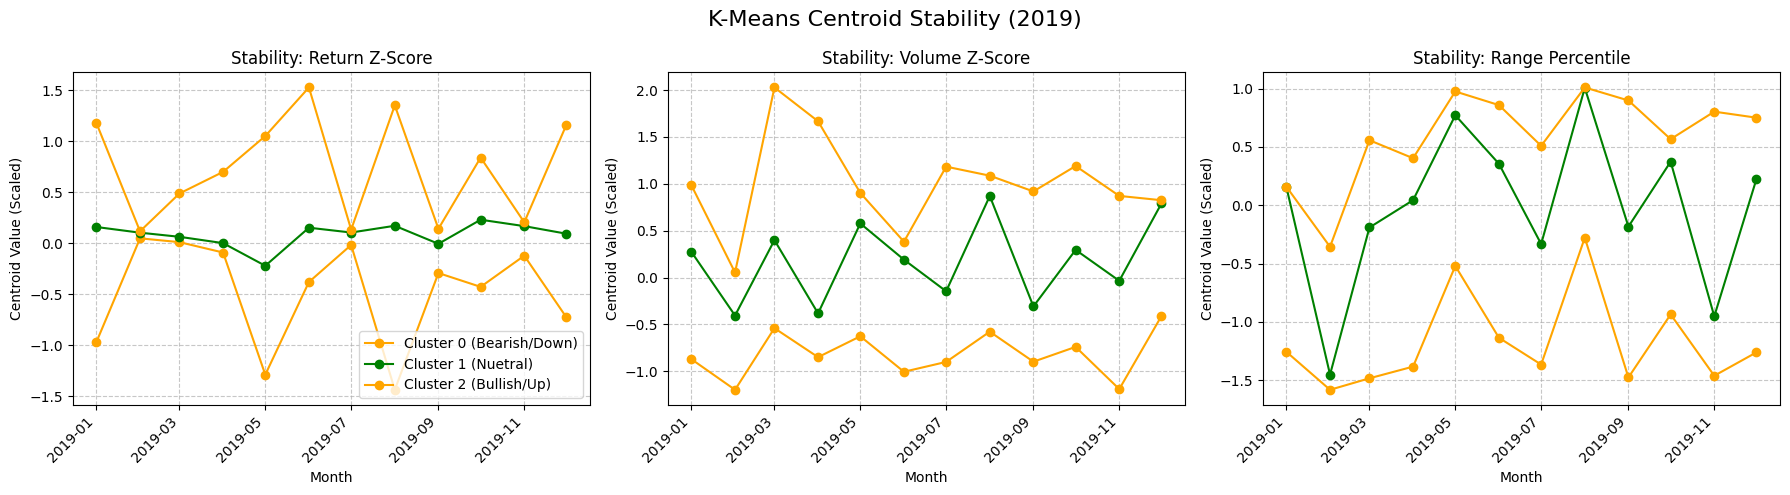

In [39]:
def check_centroid_stability(data_dict, k=3):
  all_dfs = []

  for ticker, df in data_dict.items():
    all_dfs.append(df[['ret_z_scaled', 'vol_z_scaled', 'range_pct_scaled']].dropna())
  big_df = pd.concat(all_dfs)

  months = pd.date_range('2019-01-01', '2019-12-01', freq='MS')
  prev_centers = None
  history = {
      0: {i: [] for i in range(k)},
      1: {i: [] for i in range(k)},
      2: {i: [] for i in range(k)}
  }

  valid_months = []
  for m in months:
    mask = (big_df.index >= m) & (big_df.index < m + pd.offsets.MonthEnd(1))
    monthly_data = big_df[mask]

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(monthly_data)
    centers = np.sort(kmeans.cluster_centers_, axis=0)
    sorted_idx = np.argsort(centers[:, 0])
    sroted_centers = centers[sorted_idx]

    valid_months.append(m)

    for cluster_idx in range(k):
      for feature_idx in range(3):
        val = sroted_centers[cluster_idx, feature_idx]
        history[feature_idx][cluster_idx].append(val)
  feature_names = ['Return Z-Score', 'Volume Z-Score', 'Range Percentile']
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))

  colors = ['orange', 'green', 'orange']
  labels = ['Cluster 0 (Bearish/Down)', 'Cluster 1 (Nuetral)', 'Cluster 2 (Bullish/Up)']

  for feature_idx, ax in enumerate(axes):
    for cluster_idx in range(k):
      ax.plot(valid_months, history[feature_idx][cluster_idx],
              marker='o', label=labels[cluster_idx],
              color=colors[cluster_idx])

    ax.set_title(f"Stability: {feature_names[feature_idx]}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Centroid Value (Scaled)")
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    if feature_idx == 0:
      ax.legend()
  plt.suptitle("K-Means Centroid Stability (2019)", fontsize=16)
  plt.tight_layout()
  plt.savefig(plot_path+'/kmeans_cluster_stability.png')
  plt.show()

check_centroid_stability(final_data)

## **Deliverables:**

In [40]:
def create_ticker_table(data_dict):
  all_rows = []

  for ticker, df in data_dict.items():
    temp = df[['ret', 'kmeans_anomaly', 'dbscan_anomaly']].copy()
    temp['ticker'] = ticker
    # Simple thresholding anomalies column is 'anomaly'
    temp['is_anomaly'] = temp['kmeans_anomaly'] | temp['dbscan_anomaly']
    # Is return positive?
    temp['is_positive'] = temp['ret'] > 0

    all_rows.append(temp)

  return pd.concat(all_rows)

In [41]:
def create_market_table(ticker_df):

  daily_stats = ticker_df.groupby(level=0).agg({
      'is_anomaly': 'mean', # Flag rate (Was the an)
      'ret': 'mean', # Market return (Across all stocks)
      'is_positive': 'mean' # Breadth
  })

  daily_stats.columns = ['flag_rate', 'market_return', 'breadth']

  mkt_ret = daily_stats['market_return'].abs()
  rolling_95 = mkt_ret.shift(1).rolling(window=63).quantile(0.95)
  is_return_extreme = mkt_ret > rolling_95

  is_low_breadth = daily_stats['breadth'] < 0.3
  daily_stats['market_anomaly_flag'] = (is_return_extreme | is_low_breadth)

  return daily_stats

In [42]:
ticker_df = create_ticker_table(db_results)
market_df = create_market_table(ticker_df)

print("Market Layer (March 2020):")
print(market_df.loc['2020-01-01':'2020-03-31'].head(15))

market_df.reset_index().to_csv("market_day_table.csv", index=False)

Market Layer (March 2020):
            flag_rate  market_return   breadth  market_anomaly_flag
Date                                                               
2020-01-02   0.166667       0.029237  1.000000                 True
2020-01-03   0.000000      -0.011610  0.000000                 True
2020-01-06   0.000000       0.005292  0.833333                False
2020-01-07   0.000000      -0.000442  0.333333                False
2020-01-08   0.000000       0.004149  0.666667                False
2020-01-09   0.000000       0.013637  1.000000                False
2020-01-10   0.000000      -0.004220  0.333333                False
2020-01-13   0.000000       0.015440  1.000000                False
2020-01-14   0.000000      -0.010962  0.000000                 True
2020-01-15   0.000000      -0.000205  0.500000                False
2020-01-16   0.000000       0.014632  1.000000                False
2020-01-17   0.000000       0.006548  0.833333                False
2020-01-21   0.000000

### **Date Query**

* The Below Cell Requires user input.

In [43]:
def query_on_date(ticker_df, market_df):
    import pandas as pd
    import numpy as np

    try:
        date = pd.to_datetime(
            input("Enter Date in the correct Format (YYYY-MM-DD): ")
        )

        tickers = ticker_df.loc[date]
        market_on_date = market_df.loc[date].copy()

        anomalous_tickers = []

        # --- Identify reason ---
        is_low_breadth = market_on_date['breadth'] < 0.3

        # Need rolling threshold info precomputed in market_df
        is_return_extreme = market_on_date['market_anomaly_flag'] and not is_low_breadth

        if market_on_date['market_anomaly_flag']:

            if is_low_breadth:
                # Attribution: losers
                anomalous_tickers = (
                    tickers
                        .loc[tickers['ret'] < 0, 'ticker']
                        .tolist()
                )

            else:
                # Attribution: largest movers
                anomalous_tickers = (
                    tickers
                        .assign(abs_ret=lambda x: x['ret'].abs())
                        .sort_values('abs_ret', ascending=False)
                        .head(3)['ticker']
                        .tolist()
                )

        market_on_date['anomalous_tickers'] = anomalous_tickers

        print(f"\nMarket on {date.date()}")
        for k, v in market_on_date.items():
            print(k, ":", np.round(v, 4) if isinstance(v, float) else v)

        return market_on_date

    except KeyError:
        print("Data Not Found. Maybe a Trading Holiday or the Stock Market Was Closed.")


In [44]:
query_on_date(ticker_df, market_df)
''''''


Market on 2020-03-17
flag_rate : 0.0
market_return : 0.0768
breadth : 1.0
market_anomaly_flag : True
anomalous_tickers : ['NVDA', 'MSFT', 'AMD']


''

### **Monthly Mini Report**

In [45]:
def get_mini_report(data_dict, target='2020-03'):
  consensus_anomalies = []

  for ticker in data_dict.keys():
    df = data_dict[ticker]

    dates = df.loc[target].index

    for date in dates:
      s_flag = df.loc[date, 'anomaly']
      k_flag = df.loc[date, 'kmeans_anomaly']
      d_flag = df.loc[date, 'dbscan_anomaly']

      if k_flag or d_flag or s_flag:
        row = df.loc[date]
        anomaly_type = ''
        anomaly_type += "KMeans " if k_flag else ''
        anomaly_type += "DBSCAN " if d_flag else ''
        anomaly_type += row['type'] if s_flag else ''
        consensus_anomalies.append({
            'Date': date.date(),
            'Ticker': ticker,
            'type': anomaly_type.strip().replace(' ', ' + '),
            'Return': f"{row['ret']:.2%}",
            'Volume': f"{np.exp(row['log_vol']):.0f}",
            'MktFlag': True,
            'Why': (row['why'] + f"{" KMeans" if k_flag else ""}" + f"{" DBSCAN" if d_flag else ""}").strip().replace(' ', ', ')
        })

  if consensus_anomalies:
    df_res = pd.DataFrame(consensus_anomalies)
  else:
    print("No consensus anomalies found (Models disagreed or no anomalies.)")
  return df_res

In [46]:
mini_report = get_mini_report(db_results, target='2020-03')

mini_report.to_csv("Monthly_mini_report.csv")

print(f"Monthly Mini Report (UNION): ")
display(mini_report.head())

Monthly Mini Report (UNION): 


,Date,Ticker,type,Return,Volume,MktFlag,Why
0,2020-03-02,QQQ,KMeans + DBSCAN + spike + range_shock,5.16%,112933900,True,"|ret_z|>2.5, range_pct>0.95, KMeans, DBSCAN"
1,2020-03-03,QQQ,range_shock,-3.21%,131953500,True,range_pct>0.95
2,2020-03-04,QQQ,spike,4.17%,73086200,True,|ret_z|>2.5
3,2020-03-09,QQQ,KMeans + DBSCAN + crash + range_shock,-6.95%,116424000,True,"|ret_z|>2.5, range_pct>0.95, KMeans, DBSCAN"
4,2020-03-10,QQQ,spike + range_shock,5.45%,100599200,True,"|ret_z|>2.5, range_pct>0.95"
